<a href="https://colab.research.google.com/github/PCiunkiewicz/ensf-619/blob/master/colab/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet -U torch torchmetrics lightning torchvision seaborn nibabel
!git clone https://github.com/PCiunkiewicz/ensf-619.git

In [ ]:
# Optional for nightly release; may need to update cuda version tag
!pip install -U --pre torch torchvision --index-url https://download.pytorch.org/whl/nightly/cu117

In [ ]:
# Optional for TPU support; may need to update tpu-pytorch target url
!pip install cloud-tpu-client https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp39-cp39-linux_x86_64.whl

In [ ]:
!git -C ensf-619/ pull

In [1]:
import os
import sys
sys.path.insert(0, '/content/ensf-619/final_project')

from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
from torchmetrics.functional import structural_similarity_index_measure as ssim, peak_signal_noise_ratio as psnr

from utils import nrmse, nrmse2, custom_imshow
from data import load_data, DeepCascadeDataset
from model import DeepCascade
from transform import DeepCascadeTransform

NUM_WORKERS = os.cpu_count()

In [2]:
SIZE = 164

images, masks = load_data(size=SIZE, mode='newborn')
images = torch.tensor(images, dtype=torch.float32).to('cuda')
images = images.unsqueeze(1)
masks = torch.tensor(masks, dtype=torch.float32).to('cuda')

transform = DeepCascadeTransform(size=SIZE)
dataset = DeepCascadeDataset(images, masks, transform=transform)
dataset.val = True

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/ENSF619/models/DeepCascade/lightning_logs

In [3]:
model = DeepCascade.load_model('version_10').eval()
model.to('cuda')

def batch_metrics(y_pred, y_true, prefix=''):
    return {
        f'{prefix}ssim:': ssim(y_pred.unsqueeze(1), y_true.unsqueeze(1), data_range=1),
        f'{prefix}psnr:': psnr(y_pred, y_true, data_range=1),
        f'{prefix}nrmse:': nrmse(y_pred, y_true),
        f'{prefix}nrmse2:': nrmse2(y_pred, y_true)
    }

rec = []
imgs = []
pred = []
for kspace, mask, img in tqdm(DataLoader(dataset, batch_size=32)):
    rec.append(torch.abs(torch.fft.ifft2(kspace[:,0] + 1j * kspace[:,1])))
    imgs.append(img)
    pred.append(model(kspace, mask).detach())

rec = torch.cat(rec)
img = torch.cat(imgs)
pred = torch.cat(pred)

rec_metrics = batch_metrics(rec, img, prefix='rec_')
print(rec_metrics)
pred_metrics = batch_metrics(pred, img, prefix='pred_')
print(pred_metrics)

100%|██████████| 82/82 [00:28<00:00,  2.92it/s]


{'rec_ssim:': tensor(0.7178, device='cuda:0'), 'rec_psnr:': tensor(29.8037, device='cuda:0'), 'rec_nrmse:': tensor(0.2027, device='cuda:0'), 'rec_nrmse2:': tensor(0.0323, device='cuda:0')}
{'pred_ssim:': tensor(0.9510, device='cuda:0'), 'pred_psnr:': tensor(38.9592, device='cuda:0'), 'pred_nrmse:': tensor(0.0706, device='cuda:0'), 'pred_nrmse2:': tensor(0.0113, device='cuda:0')}


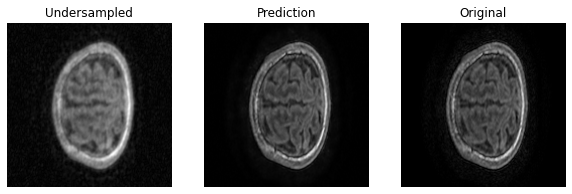

In [4]:
show_slice = 1150
custom_imshow([
    rec[show_slice].to('cpu'), 
    pred[show_slice].to('cpu'), 
    img[show_slice].to('cpu')], 
    ['Undersampled', 'Prediction', 'Original']
)